# 🎯 Talent Acquisition Using NLP Techniques

**Welcome to our Talent Matching System!**

In this notebook, we'll build an intelligent system that uses Natural Language Processing (NLP) and Large Language Models (LLMs) to find the best candidates matching specific job requirements. 

**Our Journey:**
1. 📊 Explore the dataset to understand what we're working with
2. 🧹 Preprocess and clean the data
3. 🔍 Build different search methods (TF-IDF, Sentence Transformers, FAISS)
4. 🎯 Implement semantic search with vector embeddings
5. 🔄 Add re-ranking based on user feedback

Let's begin our journey to find the perfect talent!

### 📦 Prerequisites: Modules to Install

Before we start, make sure you have the following packages installed. These are the power tools we'll use to build our talent matching system!

### Adding Our Essential Libraries

We're importing powerful libraries for different purposes:
- **Gensim**: For word embeddings and classic NLP techniques
- **Pandas**: For data manipulation and analysis
- **Matplotlib & Seaborn**: For beautiful visualizations
- **FAISS**: Facebook's library for fast similarity search
- **Sentence Transformers**: For state-of-the-art semantic embeddings
- **Custom Functions**: Our own helper functions from `functions.py`

---

## 🔧 Step 1: Setting Up Our Toolkit

In [ ]:
#using gensim for word embeddings and pandas for data manipulation
import gensim
import pandas as pd
from gensim import corpora
from gensim import models
from gensim import similarities

### adding libraries for wordcloud visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

### adding libraries for store vectors & metadata
import faiss
import numpy as np
import pandas as pd
import pickle
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm

### import functions from functions.py
from functions import *


---

## 📂 Step 2: Loading Our Talent Dataset

Now let's load our dataset containing potential candidates. Each candidate has a job title, location, and connection information.

In [ ]:

### loading the data
df_pt = pd.read_csv("../data/potential-talents.csv")
df_pt.head()

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [130]:
df_pt.columns

Index(['id', 'job_title', 'location', 'connection', 'fit'], dtype='object')

Let's peek at the column names to understand the structure of our data:

---

## 📊 Step 3: Exploratory Data Analysis (EDA)

Before we build our matching system, let's understand our data better. Think of this as getting to know our candidates!

In [131]:
df_pt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB


### 🔍 Basic Dataset Information

Let's check the data types and overall structure:

In [132]:
### EDA
columns = df_pt.columns.tolist()
id = columns[0]
job_title = columns[1]
location = columns[2]
connection = columns[3]
fit = columns[4]

for cols in [id, job_title, location, connection]:
    print(f" null values in column {cols}: {df_pt[cols].isnull().sum()}")




 null values in column id: 0
 null values in column job_title: 0
 null values in column location: 0
 null values in column connection: 0


### 🧹 Data Quality Check

Checking for missing values - we want complete information about each candidate:

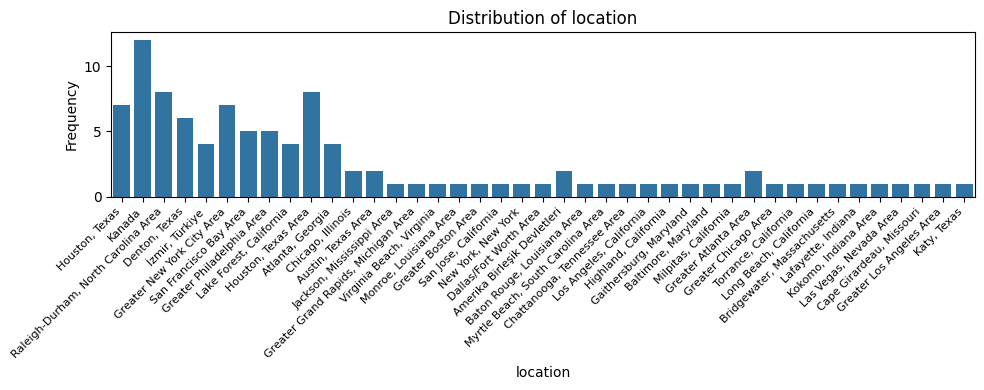

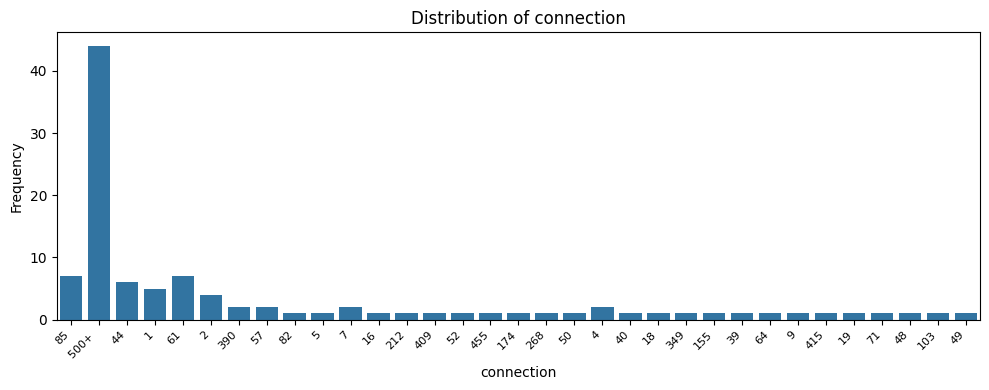

In [133]:

for col in ['location', 'connection']:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=df_pt, x=col)
    
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.tight_layout()
    
    plt.savefig(f'../images/{col}_distribution.png')
    plt.show()



### 📍 Visualizing Geographic Distribution

Where are our candidates located? Let's create visual representations:

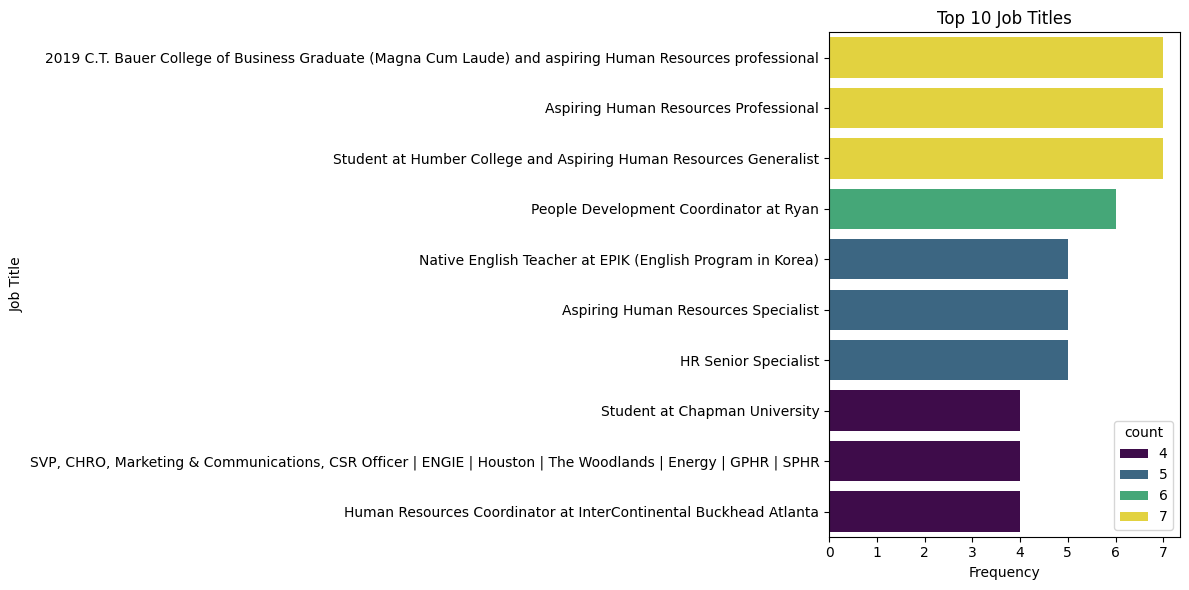

In [134]:
## plot frequency of job titles
plt.figure(figsize=(12, 6))
top_job_titles = df_pt['job_title'].value_counts().nlargest(10)
sns.barplot(x=top_job_titles.values, y=top_job_titles.index, hue=top_job_titles, palette='viridis')
plt.title('Top 10 Job Titles')
plt.xlabel('Frequency')
plt.ylabel('Job Title')
plt.tight_layout()
plt.savefig('../images/top_10_job_titles.png')

### 🏆 Most Common Job Titles

What are the most frequent job titles in our talent pool?

In [135]:
df_pt['cleaned_job_title'] = df_pt['job_title'].apply(preprocess_text)
df_pt.head()

,id,job_title,location,connection,fit,cleaned_job_title
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN,ct bauer college of business graduate magna cu...
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN,native english teacher at epik english program...
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspiring human resources professional
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,people development coordinator at ryan
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,advisory board member at celal bayar university


### 🧼 Text Preprocessing

Let's clean up the job titles by removing special characters and standardizing the format:

---

## 🔤 Step 4: Classic NLP Approach - Using Gensim

Let's start with traditional NLP techniques using Gensim to tokenize and process job titles:

In [136]:
job_title = df_pt['job_title'].apply(gensim.utils.simple_preprocess)
job_title[:5]

0    [bauer, college, of, business, graduate, magna...
1    [native, english, teacher, at, epik, english, ...
2           [aspiring, human, resources, professional]
3         [people, development, coordinator, at, ryan]
4    [advisory, board, member, at, celal, bayar, un...
Name: job_title, dtype: object

### ☁️ Word Cloud Visualization

A picture is worth a thousand words! Let's create a word cloud to visualize the most prominent terms in job titles:

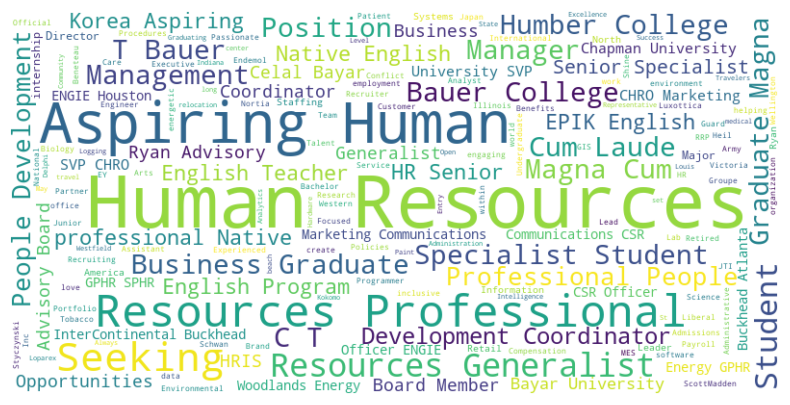

<Figure size 640x480 with 0 Axes>

In [137]:
job_titles_list = job_title.tolist()
text = " ".join(df_pt['job_title'])
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white"
).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
plt.savefig('../images/job_title_wordcloud.png')

### 🔍 Examining Tokenized Output

Let's see what the tokenized job titles look like:

In [138]:
job_title[0]

['bauer',
 'college',
 'of',
 'business',
 'graduate',
 'magna',
 'cum',
 'laude',
 'and',
 'aspiring',
 'human',
 'resources',
 'professional']

### 🚫 Understanding Stop Words

Stop words are common words like "the", "is", "at" that don't add much meaning. Let's see what Gensim considers as stop words:

In [139]:
print(gensim.parsing.preprocessing.STOPWORDS)

frozenset({'top', 'using', 'sometime', 'toward', 'beforehand', 'eleven', 'until', 'than', 'behind', 'km', 'together', 'thereupon', 'do', 'yourself', 'last', 'namely', 'and', 'he', 'used', 'fifty', 'are', 'anything', 'find', 'often', 'made', 'really', 'hence', 'with', 'throughout', 'never', 'through', 'ie', 'meanwhile', 'unless', 'indeed', 'done', 'regarding', 'that', 'somehow', 'eight', 'mine', 'me', 'mostly', 'between', 'seems', 'yet', 'how', 'ever', 'give', 'anywhere', 'out', 'make', 'ten', 'sometimes', 'whence', 'first', 'us', 'all', 'be', 'always', 'any', 'next', 'fill', 'five', 'con', 'why', 'whom', 'one', 'inc', 'whose', 'latter', 'enough', 'during', 'from', 'thick', 'towards', 'down', 'someone', 'take', 'sincere', 'bill', 'few', 'him', 'might', 'too', 'has', 'almost', 'herself', 'thereafter', 'serious', 'along', 'fifteen', 'sixty', 'against', 'less', 'whereby', 'whereupon', 'everything', 'alone', 'other', 'became', 'herein', 'others', 'these', 'see', 'everyone', 'full', 'seem', 

### 🧹 Removing Stop Words and Low-Frequency Terms

Now we'll clean our text by:
1. Removing stop words that don't add meaning
2. Filtering out words that appear only once (likely typos or rare terms)

In [140]:
# create a set of frequently used words
stop_words = set(gensim.parsing.preprocessing.STOPWORDS)
# remove stop words from job titles
texts = [[word for word in doc if word not in stop_words] for doc in job_title]
# count word frequencies
from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

# only keep words that appear more than once
processed_corpus = [[token for token in text if frequency[token] > 1] for text in texts]
print(processed_corpus[:5])

[['bauer', 'college', 'business', 'graduate', 'magna', 'cum', 'laude', 'aspiring', 'human', 'resources', 'professional'], ['native', 'english', 'teacher', 'epik', 'english', 'program', 'korea'], ['aspiring', 'human', 'resources', 'professional'], ['people', 'development', 'coordinator', 'ryan'], ['advisory', 'board', 'member', 'celal', 'bayar', 'university']]


Let's examine the full processed corpus:

In [141]:
print(processed_corpus)

[['bauer', 'college', 'business', 'graduate', 'magna', 'cum', 'laude', 'aspiring', 'human', 'resources', 'professional'], ['native', 'english', 'teacher', 'epik', 'english', 'program', 'korea'], ['aspiring', 'human', 'resources', 'professional'], ['people', 'development', 'coordinator', 'ryan'], ['advisory', 'board', 'member', 'celal', 'bayar', 'university'], ['aspiring', 'human', 'resources', 'specialist'], ['student', 'humber', 'college', 'aspiring', 'human', 'resources', 'generalist'], ['hr', 'senior', 'specialist'], ['student', 'humber', 'college', 'aspiring', 'human', 'resources', 'generalist'], ['seeking', 'human', 'resources', 'hris', 'generalist', 'positions'], ['student', 'chapman', 'university'], ['svp', 'chro', 'marketing', 'communications', 'csr', 'officer', 'engie', 'houston', 'woodlands', 'energy', 'gphr', 'sphr'], ['human', 'resources', 'coordinator', 'buckhead', 'atlanta'], ['bauer', 'college', 'business', 'graduate', 'magna', 'cum', 'laude', 'aspiring', 'human', 'resou

### 📚 Creating a Dictionary

A dictionary maps each unique word to a numerical ID - this is how computers understand text:

In [142]:

dictionary = corpora.Dictionary(processed_corpus)
print(dictionary)
print(dictionary.token2id)

Dictionary<65 unique tokens: ['aspiring', 'bauer', 'business', 'college', 'cum']...>
{'aspiring': 0, 'bauer': 1, 'business': 2, 'college': 3, 'cum': 4, 'graduate': 5, 'human': 6, 'laude': 7, 'magna': 8, 'professional': 9, 'resources': 10, 'english': 11, 'epik': 12, 'korea': 13, 'native': 14, 'program': 15, 'teacher': 16, 'coordinator': 17, 'development': 18, 'people': 19, 'ryan': 20, 'advisory': 21, 'bayar': 22, 'board': 23, 'celal': 24, 'member': 25, 'university': 26, 'specialist': 27, 'generalist': 28, 'humber': 29, 'student': 30, 'hr': 31, 'senior': 32, 'hris': 33, 'positions': 34, 'seeking': 35, 'chapman': 36, 'chro': 37, 'communications': 38, 'csr': 39, 'energy': 40, 'engie': 41, 'gphr': 42, 'houston': 43, 'marketing': 44, 'officer': 45, 'sphr': 46, 'svp': 47, 'woodlands': 48, 'atlanta': 49, 'buckhead': 50, 'internship': 51, 'management': 52, 'opportunities': 53, 'manager': 54, 'retail': 55, 'staffing': 56, 'america': 57, 'director': 58, 'north': 59, 'position': 60, 'major': 61, '

How many unique terms do we have?

In [143]:
print(len(dictionary))

65


### 🎒 Creating Bag-of-Words Representation

Converting our text into numerical format (word_id, frequency) pairs:

In [144]:
bow_corpus =[dictionary.doc2bow(text) for text in processed_corpus]
print(bow_corpus[:5])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1)], [(11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1)], [(0, 1), (6, 1), (9, 1), (10, 1)], [(17, 1), (18, 1), (19, 1), (20, 1)], [(21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1)]]


### 📊 Training TF-IDF Model

TF-IDF (Term Frequency-Inverse Document Frequency) helps identify important words by considering both:
- How often a word appears in a document (TF)
- How rare the word is across all documents (IDF)

This gives more weight to distinctive, meaningful terms!

In [145]:
# train the model
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
for doc in corpus_tfidf:
    print(doc)

[(0, 0.15409025871479304), (1, 0.38181197519664134), (2, 0.31785994113068355), (3, 0.28373757014367385), (4, 0.38181197519664134), (5, 0.38181197519664134), (6, 0.07548810304306029), (7, 0.38181197519664134), (8, 0.38181197519664134), (9, 0.2332711123621775), (10, 0.07548810304306029)]
[(11, 0.6666666666666667), (12, 0.33333333333333337), (13, 0.33333333333333337), (14, 0.33333333333333337), (15, 0.33333333333333337), (16, 0.33333333333333337)]
[(0, 0.514905501818844), (6, 0.252249817106758), (9, 0.7794949542722511), (10, 0.252249817106758)]
[(17, 0.4282922112779002), (18, 0.5217169672528987), (19, 0.5217169672528987), (20, 0.5217169672528987)]
[(21, 0.42877361248588103), (22, 0.42877361248588103), (23, 0.42877361248588103), (24, 0.42877361248588103), (25, 0.42877361248588103), (26, 0.28419350129627785)]
[(0, 0.4298555394513991), (6, 0.2105842350216153), (10, 0.2105842350216153), (27, 0.8523689196138423)]
[(0, 0.24004117745157263), (3, 0.4420052311716772), (6, 0.1175950594747249), (10,

### 🔗 Creating a Similarity Index

Building an index that allows us to quickly find similar job titles based on TF-IDF scores:

In [146]:
index = similarities.SparseMatrixSimilarity(tfidf[bow_corpus], num_features=len(dictionary))

### 🎯 Testing TF-IDF Search

Let's test our search with a query: "Aspiring Human Resources Specialist"

In [147]:
query_doc = "Aspiring Human Resources Specialist".lower()
query_bow = dictionary.doc2bow(gensim.utils.simple_preprocess(query_doc))
similarity = index[tfidf[query_bow]]
print(similarity)

[0.09802976 0.         0.32757464 0.         0.         0.9999999
 0.15271038 0.40225926 0.15271038 0.04132142 0.         0.
 0.04301821 0.09802976 0.09802976 0.         0.32757464 0.
 0.09802976 0.         0.32757464 0.         0.         0.9999999
 0.15271038 0.40225926 0.12709105 0.05814571 0.12709105 0.05814571
 0.09802976 0.         0.32757464 0.         0.         0.9999999
 0.15271038 0.40225926 0.15271038 0.04132142 0.         0.
 0.04301821 0.09802976 0.         0.32757464 0.         0.
 0.9999999  0.15271038 0.40225926 0.15271038 0.04132142 0.
 0.         0.04301821 0.09802976 0.32757464 0.         0.9999999
 0.40225926 0.04132142 0.         0.         0.04301821 0.13243726
 0.05168647 0.90289766 0.03373469 0.04570235 0.10487389 0.11745628
 0.1763608  0.12393124 0.05033144 0.32757464 0.03904483 0.10487389
 0.18303634 0.         0.06058946 0.15459102 0.         0.05168647
 0.         0.30725774 0.         0.04871079 0.06198353 0.
 0.         0.         0.         0.05814571 0.

#### 🏅 Top 10 Most Similar Results

Let's see which candidates match best:

In [148]:
## top 10 similar documents
top_10 = sorted(enumerate(similarity), key=lambda item: -item[1])[:10]
print("Top 10 similar documents (index, similarity score):")
for doc_position, doc_score in top_10:
    print(f"Document {doc_position}: Similarity Score {doc_score}")

Top 10 similar documents (index, similarity score):
Document 5: Similarity Score 0.9999998807907104
Document 23: Similarity Score 0.9999998807907104
Document 35: Similarity Score 0.9999998807907104
Document 48: Similarity Score 0.9999998807907104
Document 59: Similarity Score 0.9999998807907104
Document 67: Similarity Score 0.9028976559638977
Document 7: Similarity Score 0.4022592604160309
Document 25: Similarity Score 0.4022592604160309
Document 37: Similarity Score 0.4022592604160309
Document 50: Similarity Score 0.4022592604160309


View all results sorted by similarity:

In [149]:
for i, sim in sorted(enumerate(similarity), key=lambda item: -item[1], reverse=False):
    print(f"Document {i}: Similarity {sim}")

Document 5: Similarity 0.9999998807907104
Document 23: Similarity 0.9999998807907104
Document 35: Similarity 0.9999998807907104
Document 48: Similarity 0.9999998807907104
Document 59: Similarity 0.9999998807907104
Document 67: Similarity 0.9028976559638977
Document 7: Similarity 0.4022592604160309
Document 25: Similarity 0.4022592604160309
Document 37: Similarity 0.4022592604160309
Document 50: Similarity 0.4022592604160309
Document 60: Similarity 0.4022592604160309
Document 2: Similarity 0.32757464051246643
Document 16: Similarity 0.32757464051246643
Document 20: Similarity 0.32757464051246643
Document 32: Similarity 0.32757464051246643
Document 45: Similarity 0.32757464051246643
Document 57: Similarity 0.32757464051246643
Document 75: Similarity 0.32757464051246643
Document 96: Similarity 0.32757464051246643
Document 85: Similarity 0.307257741689682
Document 78: Similarity 0.18303634226322174
Document 72: Similarity 0.17636080086231232
Document 99: Similarity 0.17636080086231232
Docu

Display actual job titles with their similarity scores:

In [150]:
for doc, as_text in zip(df_pt['job_title'], top_10):
    print(f"Document: {doc} \nSimilarity Score: {as_text}\n")

Document: 2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional 
Similarity Score: (5, 0.9999999)

Document: Native English Teacher at EPIK (English Program in Korea) 
Similarity Score: (23, 0.9999999)

Document: Aspiring Human Resources Professional 
Similarity Score: (35, 0.9999999)

Document: People Development Coordinator at Ryan 
Similarity Score: (48, 0.9999999)

Document: Advisory Board Member at Celal Bayar University 
Similarity Score: (59, 0.9999999)

Document: Aspiring Human Resources Specialist 
Similarity Score: (67, 0.90289766)

Document: Student at Humber College and Aspiring Human Resources Generalist 
Similarity Score: (7, 0.40225926)

Document: HR Senior Specialist 
Similarity Score: (25, 0.40225926)

Document: Student at Humber College and Aspiring Human Resources Generalist 
Similarity Score: (37, 0.40225926)

Document: Seeking Human Resources HRIS and Generalist Positions 
Similarity Score: (50, 0.40225926)



---

## 🚀 Step 5: Advanced Approach - Sentence Transformers

Now let's upgrade to modern deep learning! Sentence Transformers use neural networks to understand semantic meaning, not just word matching. This captures context and meaning much better than TF-IDF!

In [151]:
from sentence_transformers import SentenceTransformer, util

model_tf = SentenceTransformer("all-mpnet-base-v2")

query = "Aspiring Human Resources Professional | An energetic and Team-Focused Leader"
docs = df_pt['job_title'].tolist()
embeddings = model_tf.encode(docs, convert_to_tensor=True)
query_embedding = model_tf.encode(query, convert_to_tensor=True)

scores = util.cos_sim(query_embedding, embeddings)
### print scores of each document along with document for top 10
top_10_indices = np.argsort(-scores[0].cpu().numpy())[:10]
top_10_scores = scores[0][top_10_indices]
top_10_docs = [docs[i] for i in top_10_indices]

# for score, doc, index in zip(top_10_scores, top_10_docs, top_10_indices):
#     print(f"Score: {score:.4f}\tDocument: {doc}\tIndex: {docs.index(doc)}")

for score, doc, index in zip(top_10_scores, top_10_docs, top_10_indices):
    print(f"Score: {score:.4f}\tDocument: {doc}\tIndex: {index}")




Score: 1.0000	Document: Aspiring Human Resources Professional | An energetic and Team-Focused Leader	Index: 81
Score: 0.8231	Document: Aspiring Human Resources Professional	Index: 20
Score: 0.8231	Document: Aspiring Human Resources Professional	Index: 45
Score: 0.8231	Document: Aspiring Human Resources Professional	Index: 32
Score: 0.8231	Document: Aspiring Human Resources Professional	Index: 57
Score: 0.8231	Document: Aspiring Human Resources Professional	Index: 16
Score: 0.8231	Document: Aspiring Human Resources Professional	Index: 2
Score: 0.8231	Document: Aspiring Human Resources Professional	Index: 96
Score: 0.7780	Document: Aspiring Human Resources Professional | Passionate about helping to create an inclusive and engaging work environment	Index: 75
Score: 0.7595	Document: Aspiring Human Resources Specialist	Index: 35


### 📐 Understanding Embeddings

Let's check the shape of our vector embeddings:

In [152]:
embeddings.shape

torch.Size([104, 768])

### 💾 Saving Embeddings

Let's save these embeddings so we don't have to recompute them every time:

In [153]:
np.save('../embeddings/pt_job_title_embeddings_model_tf.npy', embeddings)

### 📥 Loading Pre-computed Embeddings

Load the embeddings we saved earlier:

In [154]:
# loading the embeddings
embeddings = np.load('../embeddings/pt_job_title_embeddings_model_tf.npy')

Verify the dimensions of our embeddings:

In [155]:
shape = embeddings.shape
print('shape of embeddings: ',shape)
d = embeddings.shape[1]  # dimension of the embeddings
print('dimensionality of each embedding vector: ',d)

shape of embeddings:  (104, 768)
dimensionality of each embedding vector:  768


---

## ⚡ Step 6: FAISS - Lightning-Fast Similarity Search

FAISS (Facebook AI Similarity Search) is a library for efficient similarity search. It can search through millions of vectors in milliseconds!

In [156]:
import faiss
import pickle
from sentence_transformers import SentenceTransformer

Import the necessary libraries for FAISS:

### 🏗️ Building the FAISS Index

We're creating a searchable index with:
- **E5 Model**: A powerful embedding model optimized for retrieval
- **Vector Store**: FAISS index for fast similarity search
- **Metadata**: Job descriptions with all relevant information

In [157]:
MODEL_NAME = "intfloat/e5-base-v2"   # great for retrieval; or "all-mpnet-base-v2"
INDEX_PATH = "../data/jd_model_e5.index"
META_PATH  = "../data/jd_meta_model_e5.pkl"

model = SentenceTransformer(MODEL_NAME)
#docs = ["passage: " + t for t in df_pt["job_title"].tolist()]
docs = (
    "passage: " +
    df_pt.astype(str)
         .apply(lambda r: " | ".join(f"{c}: {r[c]}" for c in df_pt.columns), axis=1)
).tolist()

emb = model.encode(docs, batch_size=64, show_progress_bar=True, normalize_embeddings=True)
emb = emb.astype("float32")

## saving embeddings
np.save('../embeddings/pt_job_title_embeddings_model_e5.npy', emb)

d = emb.shape[1]  # vector dimension

# Cosine similarity = inner product when vectors are normalized
index = faiss.IndexFlatIP(d)
index.add(emb)


# Save
faiss.write_index(index, INDEX_PATH)
with open(META_PATH, "wb") as f:
    pickle.dump(df_pt.to_dict(orient="records"), f)

print(f"Indexed {index.ntotal} job descriptions. dim={d}")

Batches: 100%|██████████| 2/2 [00:18<00:00,  9.39s/it]

Indexed 104 job descriptions. dim=768


---

## 🔎 Step 7: Semantic Search in Action!

Now let's use our search system! We'll use the `search_by_vector` and `normalize` functions from our `functions.py` helper module.

In [158]:
## ask user for querytext input
# querytext = "Looking for a Software Engineer with experience in Python and Machine Learning."
# print(f"input query: {querytext}")


print(f'enter a job title to search:')
querytext = input()
print(f"you want to search the job title: {querytext}")

# querytext = input("Enter a job title to search: ").strip()
# location = input("Preferred location (optional): ").strip()

# print(f"Searching for: {querytext}" + (f" in {location}" if location else ""))

# e5_query = f"query: Target title: {querytext}. " + (f"Preferred location: {location}. " if location else "")


enter a job title to search:


you want to search the job title: 


### 🔍 Performing the Search

Loading the index and executing the semantic search:

In [159]:
# Reload functions module to get updated search_by_vector
import importlib
import functions
importlib.reload(functions)

# Load the FAISS index and metadata
index = faiss.read_index(INDEX_PATH)
with open(META_PATH, "rb") as f:
    meta = pickle.load(f)

# Create query vector from querytext
qv_base = functions.normalize(
    model.encode(["query: " + querytext], normalize_embeddings=True)[0]
)

# Search using the query vector, passing index and meta
results = functions.search_by_vector(qv_base, index_obj=index, meta_obj=meta, top_k=10, retrieve_k=50)
for r in results:
    print(r)

{'rank': 1, 'id': 94, 'faiss_id': 93, 'score': 0.7744, 'raw_score': 0.7744, 'job_title': 'Seeking Human  Resources Opportunities. Open to travel and relocation.', 'location': 'Amerika Birleşik Devletleri'}
{'rank': 2, 'id': 76, 'faiss_id': 75, 'score': 0.7726, 'raw_score': 0.7726, 'job_title': 'Aspiring Human Resources Professional | Passionate about helping to create an inclusive and engaging work environment', 'location': 'New York, New York'}
{'rank': 3, 'id': 77, 'faiss_id': 76, 'score': 0.7716, 'raw_score': 0.7716, 'job_title': 'Human Resources|\nConflict Management|\nPolicies & Procedures|Talent Management|Benefits & Compensation', 'location': 'Dallas/Fort Worth Area'}
{'rank': 4, 'id': 1, 'faiss_id': 0, 'score': 0.7712, 'raw_score': 0.7712, 'job_title': '2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional', 'location': 'Houston, Texas'}
{'rank': 5, 'id': 87, 'faiss_id': 86, 'score': 0.7709, 'raw_score': 0.7709, 'job_title': 'B

### 🎨 Pretty Print Results

Display the results in a nice, readable format:

In [160]:
## pretty print results
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(results)



[   {   'faiss_id': 93,
        'id': 94,
        'job_title': 'Seeking Human  Resources Opportunities. Open to travel '
                     'and relocation.',
        'location': 'Amerika Birleşik Devletleri',
        'rank': 1,
        'raw_score': 0.7744,
        'score': 0.7744},
    {   'faiss_id': 75,
        'id': 76,
        'job_title': 'Aspiring Human Resources Professional | Passionate about '
                     'helping to create an inclusive and engaging work '
                     'environment',
        'location': 'New York, New York',
        'rank': 2,
        'raw_score': 0.7726,
        'score': 0.7726},
    {   'faiss_id': 76,
        'id': 77,
        'job_title': 'Human Resources|\n'
                     'Conflict Management|\n'
                     'Policies & Procedures|Talent Management|Benefits & '
                     'Compensation',
        'location': 'Dallas/Fort Worth Area',
        'rank': 3,
        'raw_score': 0.7716,
        'score': 0.7716},
    

### 📊 Convert to DataFrame

Transform results into a pandas DataFrame for easier analysis:

In [161]:
## save from json to dataframe
import pandas as pd
df_results = pd.DataFrame(results, columns=["score","faiss_id", "id", "job_title", "location"])
df_results

,score,faiss_id,id,job_title,location
0,0.7744,93,94,Seeking Human Resources Opportunities. Open t...,Amerika Birleşik Devletleri
1,0.7726,75,76,Aspiring Human Resources Professional | Passio...,"New York, New York"
2,0.7716,76,77,Human Resources|\nConflict Management|\nPolici...,Dallas/Fort Worth Area
3,0.7712,0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas"
4,0.7709,86,87,Bachelor of Science in Biology from Victoria U...,"Baltimore, Maryland"
5,0.7703,14,15,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas"
6,0.7702,73,74,Human Resources Professional,Greater Boston Area
7,0.7699,98,99,Seeking Human Resources Position,"Las Vegas, Nevada Area"
8,0.7698,18,19,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas"
9,0.7696,13,14,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas"


In [162]:
---

## ⭐ Step 8: Human-in-the-Loop Re-ranking

Sometimes the algorithm needs human guidance! Let's implement a feedback mechanism where you can "star" a candidate you like, and the system will adjust to find more similar profiles.

SyntaxError: unterminated string literal (detected at line 5) (340335101.py, line 5)

Save the selected candidate's FAISS ID:

In [ ]:
# starring the results for re-rank
starred_faiss_id = results[selected_index]["faiss_id"] 

### 🎯 Retrieve the Starred Candidate's Vector

Get the embedding vector of the candidate you liked:

In [ ]:
## get starred vector from FAISS
v_star = normalize(index.reconstruct(starred_faiss_id))


### 🔄 Blend Query with Feedback

Combine your original query with the candidate you liked. The `alpha` parameter controls how much weight to give to your feedback:
- **alpha = 0**: Trust only the original query
- **alpha = 1**: Trust only your starred choice
- **alpha = 0.5**: Balance both equally

In [ ]:
alpha = 0.5  # trust in human feedback (0–1)

qv_reranked = normalize((1 - alpha) * qv_base + alpha * v_star)

### 🔁 Execute Re-ranked Search

Now search again with the improved query that incorporates your feedback:

In [ ]:
#results = search_by_vector(qv_base, top_k=10, threshold=0.6, retrieve_k=50)
reranked_results = search_by_vector(qv_reranked, top_k=10, retrieve_k=50)

print("🔁 Re-ranked results:\n")
for r in reranked_results:
    print(f"#{r['rank']:2d} | score={r['score']:.3f} | {r['job_title']} ({r['location']})")

🔁 Re-ranked results:

# 1 | score=0.968 | Aspiring Human Resources Professional | An energetic and Team-Focused Leader (Austin, Texas Area)
# 2 | score=0.931 | Aspiring Human Resources Specialist (Greater New York City Area)
# 3 | score=0.929 | Aspiring Human Resources Specialist (Greater New York City Area)
# 4 | score=0.929 | Aspiring Human Resources Specialist (Greater New York City Area)
# 5 | score=0.928 | Aspiring Human Resources Specialist (Greater New York City Area)
# 6 | score=0.928 | Aspiring Human Resources Specialist (Greater New York City Area)
# 7 | score=0.925 | Aspiring Human Resources Professional | Passionate about helping to create an inclusive and engaging work environment (New York, New York)
# 8 | score=0.921 | Aspiring Human Resources Professional (Raleigh-Durham, North Carolina Area)
# 9 | score=0.920 | Aspiring Human Resources Professional (Raleigh-Durham, North Carolina Area)
#10 | score=0.920 | Aspiring Human Resources Professional (Raleigh-Durham, North Car